In [70]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
# read file
user_engagement = pd.read_csv('takehome_user_engagement.csv')

In [72]:
# read file
users = pd.read_excel('takehome_users.xlsx')

In [73]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [74]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [75]:
# check missing values
users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [76]:
# check missing values
user_engagement.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [81]:
# convert column to datetime format
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])

In [82]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [83]:
# sort values
user_engagement = user_engagement.sort_values(by=['user_id','time_stamp'])

In [85]:
# get all unique users in user_engagement
total_users = list(user_engagement['user_id'].unique())

In [86]:
# create inital values for users' "adopted" status
adopted = [0.0] * len(total_users)

In [87]:
# create dataframe with user id and adopted status
adopted_user = pd.DataFrame({'adopted': adopted}, index=total_users)

In [88]:
# check if a user has at least three login in any 7-day period
adopted = []
for i in range(user_engagement.shape[0]-2):    # iterate over every row except the last two rows
    user_1 = user_engagement.loc[i, 'user_id']  # the user id in that row
    user_2 = user_engagement.loc[i+2, 'user_id']  # the user id in the 3rd row after
    time_1 = user_engagement.loc[i, 'time_stamp'] # the time in that row
    time_2 = user_engagement.loc[i+2, 'time_stamp']  # the time in the 3rd row after
    user_cond = (user_1 == user_2)    # user ids are same in the initial row and the 3rd row after
    time_cond = ((time_2 - time_1) < timedelta(days=7))  # time difference is within 7 days
    if (user_cond & time_cond): # if the user is the same and the time difference is within 7 days in the 3rd row after
        adopted_user.loc[user_1,'adopted'] = 1  # change the adopted status to 1
    

In [90]:
# reset index 
adopted_user = adopted_user.reset_index()

In [92]:
# change column name
adopted_user = adopted_user.rename(columns={'index':'user_id'})

In [93]:
adopted_user.head()

,user_id,adopted
0,1,0.0
1,2,1.0
2,3,0.0
3,4,0.0
4,5,0.0


In [94]:
# merge table
users = users.merge(adopted_user, left_on='object_id', right_on='user_id')

In [95]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0.0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,1.0
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,0.0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,0.0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,0.0


In [96]:
# see if column "creation_source" has different values in different adopted status
users.groupby('adopted')['creation_source'].value_counts()

adopted  creation_source   
0.0      ORG_INVITE            2635
         SIGNUP                1605
         GUEST_INVITE          1228
         SIGNUP_GOOGLE_AUTH    1153
         PERSONAL_PROJECTS      600
1.0      ORG_INVITE             553
         GUEST_INVITE           360
         SIGNUP                 293
         SIGNUP_GOOGLE_AUTH     232
         PERSONAL_PROJECTS      164
Name: creation_source, dtype: int64

In [97]:
# see if column "opted_in_to_mailing_list" has different values in different adopted status
users.groupby('adopted')['opted_in_to_mailing_list'].value_counts()

adopted  opted_in_to_mailing_list
0.0      0                           5409
         1                           1812
1.0      0                           1188
         1                            414
Name: opted_in_to_mailing_list, dtype: int64

In [98]:
# see if column "enabled_for_marketing_drip" has different values in different adopted status
users.groupby('adopted')['enabled_for_marketing_drip'].value_counts()

adopted  enabled_for_marketing_drip
0.0      0                             6126
         1                             1095
1.0      0                             1356
         1                              246
Name: enabled_for_marketing_drip, dtype: int64

In [123]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [120]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   object_id                       8823 non-null   int64         
 1   creation_time                   8823 non-null   datetime64[ns]
 2   name                            8823 non-null   object        
 3   email                           8823 non-null   object        
 4   creation_source                 8823 non-null   object        
 5   last_session_creation_time      8823 non-null   float64       
 6   opted_in_to_mailing_list        8823 non-null   int64         
 7   enabled_for_marketing_drip      8823 non-null   int64         
 8   org_id                          8823 non-null   int64         
 9   invited_by_user_id              4776 non-null   float64       
 10  user_id                         8823 non-null   int64         
 11  adop

In [124]:
users['last_session_creation_time']

0      2014-04-22 03:53:30
1      2014-03-31 03:45:04
2      2013-03-19 23:14:52
3      2013-05-22 08:09:28
4      2013-01-22 10:14:20
               ...        
8818   2013-09-06 06:14:15
8819   2013-01-15 18:28:37
8820   2014-04-27 12:45:16
8821   2012-06-02 11:55:59
8822   2014-01-26 08:57:12
Name: last_session_creation_time, Length: 8823, dtype: datetime64[ns]

In [145]:
users['active_time'] = (users['last_session_creation_time'] - users['creation_time']).dt.days

In [146]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,invited_by_user,last_session_creation_time_new,active_time
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,0.0,True,2014-04-22 03:53:30,0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2,1.0,True,2014-03-31 03:45:04,136
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,3,0.0,True,2013-03-19 23:14:52,0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,4,0.0,True,2013-05-22 08:09:28,1
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5,0.0,True,2013-01-22 10:14:20,5


(0.0, 100.0)

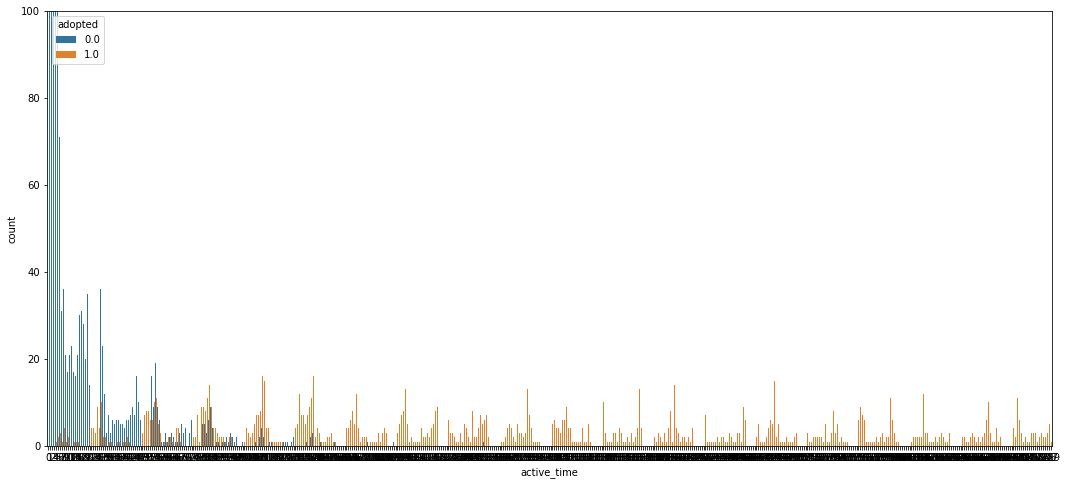

In [153]:
plt.figure(figsize=(18,8))
sns.countplot(x='active_time', data = users, hue='adopted')
plt.ylim(0, 100)

In [154]:
users.groupby('adopted')['active_time'].mean()

adopted
0.0      5.760283
1.0    300.200999
Name: active_time, dtype: float64

It is very clear that when the user has long active time, the user is more likely to be adopted. So our strategy should be encouraging users to be active all the time.